# hrv calculation 
对比了standrd fft计算PSD , 自己实现的welch方法评估PSD，以及直接调用signal包的PSD评估的对比

In [8]:
import os
import sys
import numpy as np
import pandas as pd

import signal_analysis

import matplotlib.pyplot as plt

from IPython.display import display

import signal_analysis

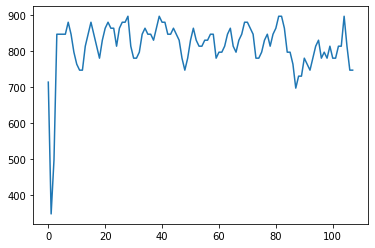

In [9]:
data_base_dir = r"C:\Users\13126\Desktop\RR1_Cleaned.txt"
test_rr = np.genfromtxt(data_base_dir) * 1000
plt.plot(test_rr)

###### time features

In [10]:
# NN50 pNN50
test_rr_diff = test_rr[1:] - test_rr[:-1]
logic_diff = np.logical_or(test_rr_diff > 50, test_rr_diff < -50)
NN50 = len(test_rr_diff[logic_diff])
pNN50 = NN50 / len(test_rr_diff)

# RMSSD
test_rr_diff = test_rr[1:] - test_rr[:-1]
RMSSD = np.sqrt(np.mean(np.power(test_rr_diff, 2)))

# SDNN
SDNN = np.std(test_rr)

# mean RR
mean_RR = np.mean(test_rr)

# mean HR
mean_HR = 60 * 1000 / np.mean(test_rr)

# build dict
time_domain_features = dict()
time_domain_features.update({"NN50" : NN50})
time_domain_features.update({"pNN50" : pNN50})
time_domain_features.update({"RMSSD" : RMSSD})
time_domain_features.update({"SDNN" : SDNN})
time_domain_features.update({"mean_RR/ms" : mean_RR})
time_domain_features.update({"mean_HR/beats/min" : mean_HR})


print(time_domain_features)

{'NN50': 12, 'pNN50': 0.11214953271028037, 'RMSSD': 60.57126070198669, 'SDNN': 70.22252235269507, 'mean_RR/ms': 814.0834074074074, 'mean_HR/beats/min': 73.70252169993319}


#####  frequency domain features

In [11]:
from hrvanalysis.extract_features import _create_timestamp_list,_create_interpolated_timestamp_list, _get_features_from_psd

from typing import List, Tuple
from collections import namedtuple
import numpy as np
import nolds
from scipy import interpolate
from scipy import signal
from astropy.stats import LombScargle
from scipy.fft import fft, fftfreq


nn_intervals = test_rr 

In [12]:
def get_freq_psd_from_nn_intervals_fft_method_signal_welch(nn_intervals):
    # ----------  Handle pandas series  ---------- #
    interpolation_method = "linear"
    sampling_frequency = 4

    nn_intervals = list(nn_intervals)

    timestamp_list = _create_timestamp_list(nn_intervals)

    # ---------- Interpolation of signal ---------- #
    funct = interpolate.interp1d(x=timestamp_list, y=nn_intervals, kind=interpolation_method)
    # funct = CubicSpline(x=timestamp_list, y=nn_intervals)


    timestamps_interpolation = _create_interpolated_timestamp_list(nn_intervals, sampling_frequency)
    nni_interpolation = funct(timestamps_interpolation)

    # ---------- Remove DC Component ---------- #
    nni_normalized = nni_interpolation - np.mean(nni_interpolation) 
    
    freq, psd = signal.welch(x=nni_normalized, fs=sampling_frequency, window='hann',
                                 nfft=4096)
    
    plt.figure()
    plt.plot(freq,psd)
    
    return freq, psd

In [13]:
def get_freq_psd_from_nn_intervals_fft_method(nn_intervals):
    # ----------  Handle pandas series  ---------- #
    interpolation_method = "linear"
    sampling_frequency = 4

    nn_intervals = list(nn_intervals)

    timestamp_list = _create_timestamp_list(nn_intervals)

    # ---------- Interpolation of signal ---------- #
    funct = interpolate.interp1d(x=timestamp_list, y=nn_intervals, kind=interpolation_method)
    # funct = CubicSpline(x=timestamp_list, y=nn_intervals)


    timestamps_interpolation = _create_interpolated_timestamp_list(nn_intervals, sampling_frequency)
    nni_interpolation = funct(timestamps_interpolation)

    # ---------- Remove DC Component ---------- #
    nni_normalized = nni_interpolation - np.mean(nni_interpolation)
    
    
    #  --------- Compute Power Spectral Density  --------- #
    nni_interpolation_len = len(nni_interpolation)
    hum_window = np.hamming(nni_interpolation_len)
    
    yf = fft(nni_normalized * hum_window)
    xf = sampling_frequency * np.arange(nni_interpolation_len) / nni_interpolation_len
    plt.plot(xf, yf)
    # xf2 = fftfreq(nni_interpolation_len, 1/sampling_frequency)[:nni_interpolation_len//2]
    # xf2 = fftfreq(nni_interpolation_len, 1/sampling_frequency)
    
    psd = np.abs(np.conj(yf) * yf) / nni_interpolation_len
    plt.figure()
    plt.plot(psd)
    
    return xf, psd


In [35]:
def get_freq_psd_from_nn_intervals_welch(nn_intervals):
     # ----------  Handle pandas series  ---------- #
    interpolation_method = "linear"
    sampling_frequency = 4
    fs = sampling_frequency
    
    nn_intervals = list(nn_intervals)

    timestamp_list = _create_timestamp_list(nn_intervals)

    # ---------- Interpolation of signal ---------- #
    funct = interpolate.interp1d(x=timestamp_list, y=nn_intervals, kind=interpolation_method)
    # funct = CubicSpline(x=timestamp_list, y=nn_intervals)


    timestamps_interpolation = _create_interpolated_timestamp_list(nn_intervals, sampling_frequency)
    nni_interpolation = funct(timestamps_interpolation)

    # ---------- Remove DC Component ---------- #
    nni_normalized = nni_interpolation - np.mean(nni_interpolation)
    
    #  --------- Compute Power Spectral Density  --------- #
    data = nni_normalized
    nni_interpolation_len = len(nni_interpolation)
    
    # Welch estimate parameters
    # segment_size = np.int32(0.5*nni_interpolation_len) # Segment size = 50 % of data length
    segment_size = 256
    overlap_fac = 0.5
    overlap_size = overlap_fac*segment_size
    fft_size = 4096
    detrend = True # If true, removes signal mean
    scale_by_freq = True
    
    # Frequency resolution
    fres = fs/segment_size
    
    ## Own implementation
    # PSD size = N/2 + 1 
    PSD_size = np.int32(fft_size/2)+1
    
    # Number of segments
    baseSegment_number = np.int32(len(data)/segment_size) # Number of initial segments
    total_segments =  np.int32(baseSegment_number + ((1-overlap_fac)**(-1) - 1 ) * (baseSegment_number - 1)) # No. segments including overlap
    window = signal.hann(segment_size) # Hann window
    
    if scale_by_freq:
        # Scale the spectrum by the norm of the window to compensate for
        # windowing loss; see Bendat & Piersol Sec 11.5.2.
        S2 = np.sum((window)**2) 
    else:
        # In this case, preserve power in the segment, not amplitude
        S2 = (np.sum(window))**2
    
    fft_segment = np.empty((total_segments,fft_size),dtype=np.complex64)
    for i in range(total_segments):
        offset_segment = np.int32(i* (1-overlap_fac)*segment_size)
        current_segment = data[offset_segment:offset_segment+segment_size]
        # Detrend (Remove mean value)   
        if detrend :
            current_segment = current_segment - np.mean(current_segment)
        windowed_segment = np.multiply(current_segment,window)
        fft_segment[i] = np.fft.fft(windowed_segment,fft_size) # fft automatically pads if n<nfft
    
    # Add FFTs of different segments
    fft_sum = np.zeros(fft_size,dtype=np.complex64)
    for segment in fft_segment:
         fft_sum += segment
    print(fft_sum[0])
    
    # Normalization including window effect on power
    powerDensity_normalization = 1/S2
    # Averaging decreases FFT variance
    powerDensity_averaging = 1/total_segments
    # Transformation from Hz.s to Hz spectrum
    if scale_by_freq:
        powerDensity_transformation = 1/fs
    else:
        powerDensity_transformation = 1
        
    # Make oneSided estimate 1st -> N+1st element
    fft_WelchEstimate_oneSided = fft_sum[0:PSD_size]

    # Convert FFT values to power density in U**2/Hz
    PSD_own = np.square(abs(fft_WelchEstimate_oneSided)) * powerDensity_averaging * powerDensity_normalization * powerDensity_transformation
    # Double frequencies except DC and Nyquist
    PSD_own[2:PSD_size-1] *= 2
    fft_freq = np.fft.fftfreq(fft_size,1/fs)
    print(fft_freq)
    freq = fft_freq[0:PSD_size]
    # Take absolute value of Nyquist frequency (negative using np.fft.fftfreq)
    freq[-1] = np.abs(freq[-1])
    
    print(powerDensity_averaging)
    print(powerDensity_normalization)
    print(powerDensity_transformation)
    print("power", PSD_own)
    plt.figure()
    plt.plot(PSD_own)
    
    
    plot = True
    ## Plots
    if plot:
        plt.figure()
        plt.plot(freq,PSD_own,label='Own implementation')
#         plt.ylim([0,0.15])
#         plt.xlim([0, fs/2])
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [dB]')
        plt.legend()
        
    return freq, PSD_own

(1375.3682+0j)
[ 0.          0.00097656  0.00195312 ... -0.00292969 -0.00195312
 -0.00097656]
1.0
0.01045751633986928
0.25
power [4.9454580e+03 4.9430098e+03 9.8714424e+03 ... 5.5465780e-02 5.1384911e-02
 2.4997938e-02]
{'lf': 540.8196123670787, 'hf': 458.24085737671703, 'lf_hf_ratio': 1.1802081889054998, 'lfnu': 54.13282065957121, 'hfnu': 45.86717934042879, 'total_power': 1237.4648975105956, 'vlf': 238.40442776679993}


d:\idle\anaconda3\envs\pyqt5_py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


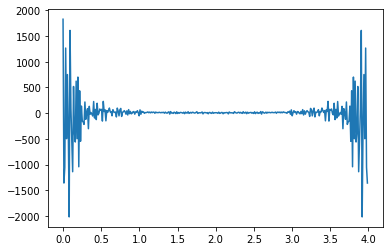

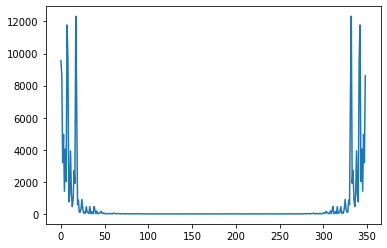

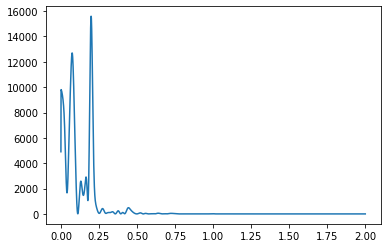

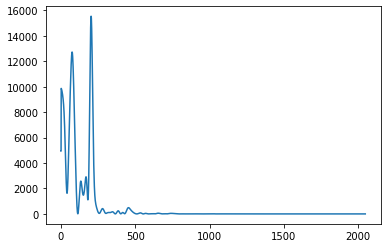

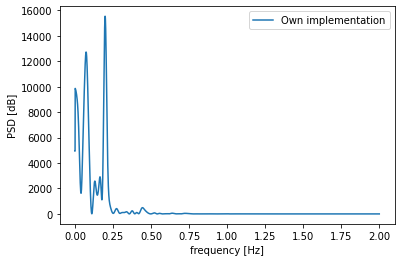

In [36]:
# ----------  Compute frequency & Power spectral density of signal  ---------- #
# freq, psd = _get_freq_psd_from_nn_intervals(nn_intervals=nn_intervals, method=method,
#                                             sampling_frequency=sampling_frequency,
#                                             interpolation_method=interpolation_method,
#                                             vlf_band=vlf_band, hf_band=hf_band)

freq, psd = get_freq_psd_from_nn_intervals_fft_method(nn_intervals=nn_intervals)
freq, psd = get_freq_psd_from_nn_intervals_fft_method_signal_welch(nn_intervals=nn_intervals)
freq, psd = get_freq_psd_from_nn_intervals_welch(nn_intervals=nn_intervals)


# ---------- Features calculation ---------- #
# Named Tuple for different frequency bands
VlfBand = namedtuple("Vlf_band", ["low", "high"])
LfBand = namedtuple("Lf_band", ["low", "high"])
HfBand = namedtuple("Hf_band", ["low", "high"])
vlf_band: namedtuple = VlfBand(0.003, 0.04)
lf_band: namedtuple = LfBand(0.04, 0.15)
hf_band: namedtuple = HfBand(0.15, 0.40)
frequency_domain_features = _get_features_from_psd(freq=freq, psd=psd,
                                                  vlf_band=vlf_band,
                                                  lf_band=lf_band,
                                                  hf_band=hf_band)
print(frequency_domain_features)


In [28]:
time_domain_features, frequency_domain_features = signal_analysis.HRV_get_time_frequency_domain(test_rr)
print(time_domain_features)
print(frequency_domain_features)

0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.
{'mean_nni': 814.8515555555555, 'sdnn': 59.46022592280725, 'sdsd': 43.18815550438258, 'nni_50': 13.0, 'pnni_50': 12.149532710280374, 'nni_20': 55.0, 'pnni_20': 51.401869158878505, 'rmssd': 43.18926900295194, 'median_nni': 829.6, 'range_nni': 398.20799999999997, 'cvsd': 0.05300262202175713, 'cvnni': 0.07297062332079371, 'mean_hr': 74.1087187048456, 'max_hr': 120.5400192864031, 'min_hr': 66.96667738133505, 'std_hr': 6.7007435094355285}
{'lf': 537.1758398248303, 'hf': 455.4726551446101, 'lf_hf_ratio': 1.1793810973224723, 'lfnu': 54.115413718666616, 'hfnu': 45.88458628133337, 'total_power': 1244.093732089341, 'vlf': 251.44523711990064}


# metrics 

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import signal_analysis

import matplotlib.pyplot as plt

from IPython.display import display

In [58]:
filepath = r"C:\Users\13126\Desktop\BCG_serialport_ecg\data\采集数据"

In [59]:
# data_name = "data_2021-04-26-23-26-01.txt"
# label_name = "data_2021-04-26-23-26-01_label - 副本.txt"

dataset_list = ['data_2021-04-28-16-18-17_xyc',
                'data_2021-05-18-21-14-19_hcq',
                'data_2021-05-17-21-45-51_mty_yj',
                'data_2021-05-17-22-08-37_shq_zzm',
                'data_2021-04-28-18-02-45_yf',
                'data_2021-05-18-21-28-29_ljr_jw',
                'data_2021-04-26-23-26-01']

In [132]:
def read_label(filepath, filename):
    filename = filename + "_label.txt"
    file_str = os.path.join(filepath, filename)
    J_peak_array = np.genfromtxt(file_str, skip_header=1, usecols=(0,))
    R_peak_array = np.genfromtxt(file_str, skip_header=1, usecols=(1,), delimiter='\t', filling_values=0)
    range_array = np.genfromtxt(file_str, skip_header=1, usecols=(2, 3, 4, 5, 6, 7, 8, 9), max_rows=1)
    range_array = np.array(list(filter(lambda p: p >= 0, range_array)))

    return J_peak_array, R_peak_array, range_array


def read_data(filepath, filename):
    filename = filename + ".txt"
    file_str = os.path.join(filepath, filename)
    data_array = np.genfromtxt(file_str, skip_header=2, skip_footer=4)

    return data_array

def check_precision_of_R_detect(detected_R_peak_array, label_R_peak_array):
    # 识别出的peak点
    hit_list = []
    # 漏检的peak点
    loss_list = []
    # 误检的peak点
    error_list = []
    
    for point in detected_R_peak_array:
        if point in label_R_peak_array or point in label_R_peak_array+1 or point in label_R_peak_array-1:
            hit_list.append(point)
        else:
            error_list.append(point)
            
    for point in label_R_peak_array:
        if point not in detected_R_peak_array and point not in detected_R_peak_array+1 and point not in detected_R_peak_array-1:
            loss_list.append(point)
            
    return hit_list, loss_list, error_list

In [133]:
label = ['R_label','R_detected', 'hit_list', 'loss_list', 'error_list']
df = pd.DataFrame(columns=label)

for filename in dataset_list:
    print(">"*30)
    print(filename)
    # read data
    data = read_data(filepath, filename)
    BCG_data = data[:, 0]
    ECG_data_raw = data[:, 1]
    ECG_data = signal_analysis.base_filter(ECG_data_raw)

    print("BCG_data:", BCG_data.shape)
    print("ECG_data:", ECG_data.shape)
    
    # get the labeled R peaklist
    J_peak_array, R_peak_array_label, range_array = read_label(filepath, filename)
    R_peak_array_label = R_peak_array_label[R_peak_array_label>0]
    print("R_peak_array_label:", R_peak_array_label.shape)
    
    # caculate R peaklist
    print("range_array:",range_array)
    R_peaklist = []
    for i in range(int(len(range_array) / 2)):
        if(range_array[2 * i + 1] != 0):
            ECG_data_temp = ECG_data[int(range_array[2 * i]):int(range_array[2 * i + 1])]
            R_peaklist_tmp = signal_analysis.J_peak_list_calculate_PanTomp(BCG_data=ECG_data_temp, sample_rate=200)
            R_peaklist_tmp = np.array(R_peaklist_tmp) + range_array[2 * i]
            R_peaklist.append(R_peaklist_tmp)
    print("R_peaklist:", len(R_peaklist))
    
    if len(R_peaklist) > 1:
        R_peaklist_temp = []
        for i in range(len(R_peaklist)):
            R_peaklist_temp = R_peaklist_temp + list(R_peaklist[i])
        R_peaklist = R_peaklist_temp
    R_peaklist_array = np.array(R_peaklist)
    R_peaklist_array = R_peaklist_array.reshape(-1)
    print("R_peaklist_array:", R_peaklist_array.shape)
    
    # compare R_peak_label with R_peak_deteced
    hit_list, loss_list, error_list = check_precision_of_R_detect(R_peaklist_array, R_peak_array_label)
#     print("R_peaklist_array:",R_peaklist_array)
#     print("R_peak_array_label:",R_peak_array_label)
    
    print("hit_list:", len(hit_list))
    print("loss_list:", len(loss_list))
    print("error_list:", len(error_list))
    
    df.loc[filename] = [R_peak_array_label, R_peaklist_array, hit_list, loss_list, error_list]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
data_2021-04-28-16-18-17_xyc
BCG_data: (49680,)
ECG_data: (49680,)
R_peak_array_label: (368,)
range_array: [    0. 49680.     0.     0.     0.     0.     0.     0.]
49680
qrs peaks indices
[   50   192   337   478   636   801   960  1129  1299  1457  1620  1783
  1936  2087  2234  2373  2513  2651  2790  2939  3093  3242  3387  3541
  3697  3841  3994  4151  4300  4452  4606  4752  4894  5037  5181  5322
  5471  5626  5776  5924  6077  6229  6374  6521  6664  6796  6934  7077
  7222  7362  7508  7661  7805  7950  8095  8238  8375  8513  8648  8777
  8905  9038  9176  9314  9455  9602  9755  9898 10052 10208 10354 10495
 10630 10762 10891 11015 11145 11274 11403 11528 11655 11784 11913 12036
 12162 12291 12417 12544 12672 12806 12941 13080 13214 13356 13503 13642
 13774 13908 14040 14180 14313 14443 14574 14708 14849 14981 15114 15253
 15391 15522 15644 15768 15897 16041 16196 16353 16508 16666 16821 16965
 17109 17253 17388 17516 17647 17774 17911 18055 1

BCG_data: (76495,)
ECG_data: (76495,)
R_peak_array_label: (622,)
range_array: [1.0000e+00 7.6494e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
76493
qrs peaks indices
[   37   175   314   453   585   719   849   987  1121  1255  1379  1606
  1826  1950  2090  2227  2365  2506  2649  2803  2939  3069  3190  3425
  3655  3896  4034  4173  4307  4432  4556  4683  4811  4937  5068  5305
  5548  5682  5831  5977  6104  6225  6454  6575  6697  6820  7050  7278
  7525  7651  7777  7899  8126  8341  8547  8766  9002  9128  9362  9599
  9726  9853  9978 10207 10432 10677 10811 10942 11070 11196 11426 11649
 11882 12003 12134 12265 12399 12530 12660 12784 13011 13234 13468 13694
 13929 14153 14365 14579 14829 14974 15121 15263 15408 15552 15694 15831
 15954 16075 16196 16319 16446 16577 16712 16853 17000 17140 17274 17401
 17631 17867 18001 18149 18300 18438 18562 18687 18815 18941 19071 19311
 19553 19675 19911 20156 20296 20430 20569 20712 20853 20985 21109 21230
 213

BCG_data: (68536,)
ECG_data: (68536,)
R_peak_array_label: (378,)
range_array: [1.0000e+00 6.8536e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
68535
qrs peaks indices
[  147   305   476   666   856  1031  1224  1425  1611  1794  1982  2172
  2348  2546  2753  2949  3136  3330  3528  3709  3894  4079  4270  4457
  4633  4792  4959  5138  5317  5457  5616  5775  5976  6167  6348  6540
  6732  6904  7088  7278  7455  7630  7821  8013  8199  8394  8599  8786
  8993  9206  9409  9612  9805  9993 10192 10382 10569 10760 10936 11132
 11326 11495 11687 11877 12059 12252 12464 12665 12874 13078 13269 13464
 13661 13843 14038 14225 14408 14597 14779 14964 15152 15332 15510 15695
 15867 16045 16226 16395 16578 16765 16952 17146 17339 17513 17690 17868
 18038 18222 18425 18609 18797 18974 19144 19323 19499 19669 19852 20044
 20219 20407 20588 20767 20966 21163 21350 21547 21736 21929 22130 22323
 22531 22734 22923 23117 23304 23481 23662 23843 24015 24211 24414 24602
 248

BCG_data: (91342,)
ECG_data: (91342,)
R_peak_array_label: (518,)
range_array: [1.0000e+00 4.1000e+03 5.4000e+03 9.1342e+04 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
4099
qrs peaks indices
[ 127  297  492  691  881 1073 1274 1459 1652 1841 2031 2219 2403 2579
 2757 2926 3117 3300 3488 3657 3838 4013]
noise peaks indices
[]
85942
qrs peaks indices
[   63   337   507   695   866  1053  1234  1416  1616  1881  2065  2221
  2402  2602  2792  2967  3160  3352  3524  3704  3894  4078  4247  4436
  4634  4822  4994  5169  5375  5580  5790  5999  6203  6403  6600  6797
  6987  7184  7384  7575  7773  7973  8164  8306  8468  8759  8971  9175
  9375  9566  9768  9961 10159 10343 10534 10730 10921 11100 11293 11480
 11665 11861 12045 12237 12433 12622 12792 12967 13151 13329 13502 13683
 13865 14049 14247 14430 14615 14813 15012 15207 15406 15602 15786 15969
 16151 16336 16518 16701 16870 17029 17199 17361 17505 17647 17809 17999
 18161 18332 18516 18683 18844 19023 19201 19361 19540 19717 198

BCG_data: (64499,)
ECG_data: (64499,)
R_peak_array_label: (360,)
range_array: [ 1000. 60000.     0.     0.     0.     0.     0.     0.]
59000
qrs peaks indices
[   26   192   361   533   696   863  1033  1192  1358  1528  1690  1856
  2025  2189  2354  2525  2694  2862  3037  3207  3375  3547  3722  3890
  4061  4229  4395  4565  4731  4893  5059  5230  5395  5568  5741  5907
  6081  6249  6413  6583  6748  6905  7073  7246  7413  7583  7756  7926
  8087  8254  8423  8583  8751  8927  9095  9268  9444  9607  9780  9955
 10116 10281 10450 10614 10775 10942 11110 11272 11444 11598 11753 11904
 12059 12219 12385 12541 12707 12875 13035 13196 13363 13527 13687 13853
 14019 14178 14343 14512 14671 14836 15005 15164 15332 15502 15671 15837
 16006 16175 16329 16493 16662 16829 16993 17162 17322 17470 17612 17765
 17914 18062 18219 18385 18553 18717 18886 19058 19221 19385 19550 19715
 19872 20037 20203 20366 20521 20685 20811 21006 21174 21347 21523 21685
 21853 22023 22195 22356 22527 22697 

In [134]:
df

,R_label,R_detected,hit_list,loss_list,error_list
data_2021-04-28-16-18-17_xyc,"[50.0, 192.0, 337.0, 478.0, 636.0, 801.0, 960....","[50.0, 192.0, 337.0, 478.0, 636.0, 801.0, 960....","[50.0, 192.0, 337.0, 478.0, 636.0, 801.0, 960....",[49673.0],[]
data_2021-05-18-21-14-19_hcq,"[52.0, 199.0, 340.0, 483.0, 628.0, 772.0, 916....","[199.0, 340.0, 483.0, 628.0, 772.0, 916.0, 106...","[199.0, 340.0, 483.0, 628.0, 772.0, 916.0, 106...","[52.0, 83124.0]","[7727.0, 11268.0, 19873.0, 44350.0, 50150.0, 5..."
data_2021-05-17-21-45-51_mty_yj,"[38.0, 176.0, 315.0, 454.0, 586.0, 720.0, 850....","[38.0, 176.0, 315.0, 454.0, 586.0, 720.0, 850....","[38.0, 176.0, 315.0, 454.0, 586.0, 720.0, 850....",[],[]
data_2021-05-17-22-08-37_shq_zzm,"[148.0, 306.0, 477.0, 667.0, 857.0, 1032.0, 12...","[148.0, 306.0, 477.0, 667.0, 857.0, 1032.0, 12...","[148.0, 306.0, 477.0, 667.0, 857.0, 1032.0, 12...",[],"[5193.0, 35580.0, 45331.0, 50956.0]"
data_2021-04-28-18-02-45_yf,"[103.0, 252.0, 404.0, 560.0, 712.0, 863.0, 101...","[103.0, 252.0, 404.0, 560.0, 712.0, 863.0, 101...","[103.0, 252.0, 404.0, 560.0, 712.0, 863.0, 101...",[],"[2393.0, 4824.0, 17430.0, 18759.0, 26414.0]"
data_2021-05-18-21-28-29_ljr_jw,"[128.0, 298.0, 493.0, 692.0, 882.0, 1074.0, 12...","[128.0, 298.0, 493.0, 692.0, 882.0, 1074.0, 12...","[128.0, 298.0, 493.0, 692.0, 882.0, 1074.0, 12...",[6965.0],"[5463.0, 7016.0, 11550.0, 11882.0, 12130.0, 13..."
data_2021-04-26-23-26-01,"[1026.0, 1192.0, 1361.0, 1533.0, 1696.0, 1863....","[1026.0, 1192.0, 1361.0, 1533.0, 1696.0, 1863....","[1026.0, 1192.0, 1361.0, 1533.0, 1696.0, 1863....","[17711.0, 21816.0, 59995.0]","[17493.0, 17662.0, 21811.0, 22758.0, 23023.0, ..."


In [135]:
# 统计结果

label_df_statistics = ['R_label/num of actual R peaks','R_detected/num of detected R peaks', 'hit_list/True Poistive', 'loss_list/False Negtives', 'error_list/False Positive']
label = ['R_label','R_detected', 'hit_list', 'loss_list', 'error_list']
df_statistics = pd.DataFrame(columns=label_df_statistics)

for filename in dataset_list:
    statistics_list = []
    for i in range(len(label)):
        statistics_list.append(len(df.loc[filename][i]))
    df_statistics.loc[filename] = statistics_list

In [136]:
df_statistics

,R_label/num of actual R peaks,R_detected/num of detected R peaks,hit_list/True Poistive,loss_list/False Negtives,error_list/False Positive
data_2021-04-28-16-18-17_xyc,368,367,367,1,0
data_2021-05-18-21-14-19_hcq,562,569,560,2,9
data_2021-05-17-21-45-51_mty_yj,622,622,622,0,0
data_2021-05-17-22-08-37_shq_zzm,378,382,378,0,4
data_2021-04-28-18-02-45_yf,235,240,235,0,5
data_2021-05-18-21-28-29_ljr_jw,518,558,517,1,41
data_2021-04-26-23-26-01,360,366,356,3,10


In [143]:
df_statistics.index = list(np.arange(0, 7))

In [144]:
df_statistics

,R_label/num of actual R peaks,R_detected/num of detected R peaks,hit_list/True Poistive,loss_list/False Negtives,error_list/False Positive
0,368,367,367,1,0
1,562,569,560,2,9
2,622,622,622,0,0
3,378,382,378,0,4
4,235,240,235,0,5
5,518,558,517,1,41
6,360,366,356,3,10


In [151]:
df_statistics.sum(axis=0).to_string
item_list = []
for item in df_statistics.sum(axis=0):
    item_list.append(item)

In [152]:
item_list

[3043.0, 3104.0, 3035.0, 7.0, 69.0]